# Installing and Importing required libraries 

In [ ]:
pip install pymannkendall

In [ ]:
pip install kats==0.1 ax-platform==0.2.3 statsmodels==0.12.2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
from datetime import datetime
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller
from kats.consts import TimeSeriesData
from kats.utils.decomposition import TimeSeriesDecomposition

# Time series Analysis for Alameda County, Industry: Police Protection, NAICS: 92212, Ownership: State Government

In [ ]:
emp = []

with open('92212_Alameda_StateGovt.csv', mode ='r') as file:

  csvFile = csv.reader(file)
  for lines in csvFile:
        emp += [int(x) for x in lines[2:5]]
print(emp)

[356, 353, 353, 335, 309, 308, 324, 316, 322, 308, 304, 306, 314, 306, 306, 317, 308, 306, 289, 303, 309, 299, 297, 295, 295, 292, 292, 286, 293, 291, 296, 295, 289, 278, 278, 282, 277, 280, 289, 292, 289, 304, 288, 292, 295, 296, 297, 305, 291, 285, 290, 289, 285, 285, 278, 277, 277, 278, 304, 308, 305, 290, 289, 292, 299, 299, 298, 303, 301, 295, 291, 315, 308, 309, 297, 297, 296, 296, 298, 299, 299, 310, 315, 323, 322, 323, 323, 335, 330, 325, 323, 317, 318, 313, 313, 313, 317, 318, 316, 303, 301, 301, 303, 305, 308, 318, 326, 340, 315, 316, 314, 316, 323, 320, 321, 312, 313, 311, 310, 311, 309, 309, 307, 310, 322, 313, 313, 312, 320, 309, 310, 317, 311, 318, 318, 314, 319, 318, 319, 322, 314, 311, 311, 314, 350, 349, 342, 345, 346, 346, 349, 356, 355, 356, 371, 359, 355, 351, 359, 355, 357, 366, 397, 359, 362, 361, 362, 359, 360, 360, 355, 350, 352, 350, 351, 352, 357, 357, 369, 365, 344, 344, 354, 345, 343, 348, 358, 348, 357, 353, 355, 360, 390, 358, 357, 339, 336, 337, 332, 330,

In [ ]:
time = pd.date_range(start='2004',end='2022',periods=len(emp))
emp_series = pd.Series(emp,index=time)

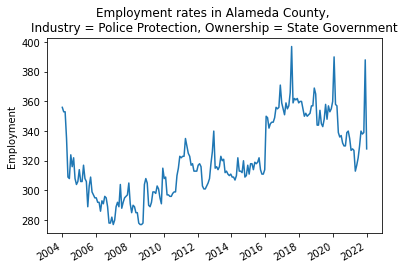

In [ ]:
emp_series.plot()
plt.title('Employment rates in Alameda County, \nIndustry = Police Protection, Ownership = State Government')
plt.ylabel('Employment')
plt.show()

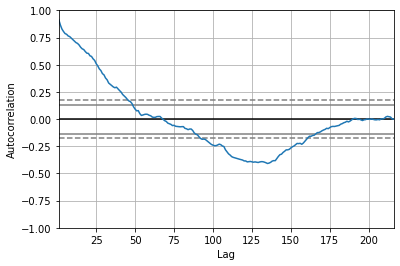

In [ ]:
"""
We will find the correlation of the time series with itself at different values of time lag. 
This will provide us information about how many time steps to use for ARIMA time series prediction.
"""
autocorrelation_plot(emp_series)
plt.show()

# Augmented Dickey-Fuller Test to check stationarity

*   Null Hypothesis: H0: The time series is non-stationary.
*   Alterate Hypothesis: HA: The time series is stationary.




In [ ]:
adfuller(emp_series)

(-2.403686240121031,
 0.14069869658388318,
 1,
 214,
 {'1%': -3.4612821203214907,
  '5%': -2.875142613826617,
  '10%': -2.574020122281422},
 1480.0458490796834)



*   Test statistic: -2.403686240121031
*   P-value: 0.14069869658388318

Since the p-value is not less than .05, we fail to reject the null hypothesis. So the time series is non-stationary. This implies that the series does not have constant mean and variance over different time instants.



# Finding trend in the time series using Mann-Kendall Trend Test

*   Null Hypothesis: H0: There is no trend.
*   Alterate Hypothesis: HA: There is a trend in the data.

In [ ]:
import pymannkendall as mk
mk.original_test(emp_series)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=11.137925934773111, Tau=0.5092592592592593, s=11825.0, var_s=1126990.3333333333, slope=0.2893909301555776, intercept=284.8904750082754)

The p-value is 0, which indicates that there is trend in the data.

# Finding Seasonality 
* We decompose the time series into different components: Trend, seasonality, and residual components

In [ ]:
df = emp_series.rename("value")
df = df.to_frame()
df.reset_index(inplace=True)
df = df.rename(columns={"index": "time"})
ts = TimeSeriesData(df)

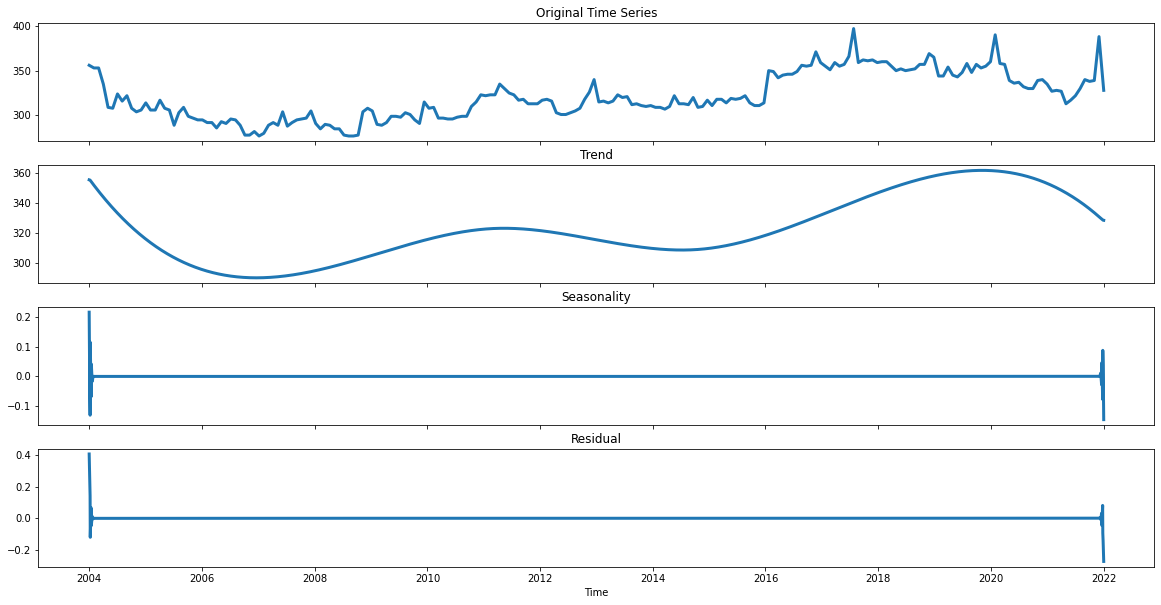

In [ ]:
decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()

* We can observe that there is no seasonality in the data. This means the employment rates do not depend much on the quarter and month of the year.

* Fast Fourier Transform Seasonality Detection

In [ ]:
from kats.detectors.seasonality import FFTDetector

fft_detector = FFTDetector(ts)
fft_detector.detector()

{'seasonality_presence': False, 'seasonalities': []}

# Time series prediction using ARIMA

In [ ]:
# Dividing the data into train(66%) and test(33%) sets
size = int(0.66 * len(emp_series))
train, test = emp_series.values[0:size], emp_series.values[size:len(emp_series)]

In [ ]:
history = list(train)
predictions = []

for t in range(len(test)):
	model = ARIMA(history, order=(25,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=311.848379, expected=311.000000
predicted=314.161209, expected=314.000000
predicted=312.396377, expected=350.000000
predicted=348.354536, expected=349.000000
predicted=340.136214, expected=342.000000
predicted=337.307275, expected=345.000000
predicted=342.953027, expected=346.000000
predicted=341.433100, expected=346.000000
predicted=348.392272, expected=349.000000
predicted=348.223922, expected=356.000000
predicted=355.204254, expected=355.000000
predicted=356.172292, expected=356.000000
predicted=351.286514, expected=371.000000
predicted=367.718723, expected=359.000000
predicted=358.703797, expected=355.000000
predicted=361.457520, expected=351.000000
predicted=351.833806, expected=359.000000
predicted=359.663378, expected=355.000000
predicted=356.555534, expected=357.000000
predicted=358.412137, expected=366.000000
predicted=363.125754, expected=397.000000
predicted=396.752152, expected=359.000000
predicted=363.459410, expected=362.000000
predicted=364.685998, expected=361

Test RMSE: 14.235


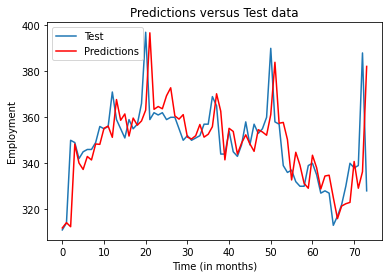

In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' %rmse)

plt.plot(test, label="Test")
plt.plot(predictions, color='red',label="Predictions")
plt.legend(loc="upper left")
plt.title('Predictions versus Test data')
plt.ylabel('Employment')
plt.xlabel('Time (in months)')
plt.show()

In [ ]:
s1 = pd.Series(test)
s2 = pd.Series(predictions)
print(s1.corr(s2, method='pearson'))

0.616364214354266


# Time series Analysis for Alameda County, Industry: Police Protection, NAICS: 92212, Ownership: Federal Government

In [ ]:
emp = []

with open('92212_Alameda_FederalGovt.csv', mode ='r') as file:

  csvFile = csv.reader(file)
  for lines in csvFile:
        emp += [int(x) for x in lines[2:5]]
print(emp)

[278, 276, 282, 283, 278, 280, 269, 278, 284, 295, 295, 298, 301, 302, 304, 351, 351, 346, 351, 355, 359, 354, 353, 349, 348, 348, 350, 348, 350, 350, 350, 349, 342, 343, 342, 327, 326, 331, 364, 369, 368, 389, 377, 380, 378, 377, 386, 383, 386, 386, 388, 389, 386, 378, 385, 389, 397, 411, 411, 412, 397, 397, 396, 398, 416, 414, 418, 416, 414, 426, 432, 432, 436, 443, 438, 434, 443, 440, 439, 443, 446, 449, 448, 456, 459, 462, 458, 457, 461, 455, 457, 454, 443, 440, 450, 439, 442, 445, 448, 453, 452, 449, 447, 451, 451, 486, 498, 456, 459, 460, 465, 469, 470, 461, 462, 461, 459, 459, 455, 456, 455, 461, 449, 471, 472, 466, 471, 467, 461, 466, 465, 462, 463, 465, 465, 460, 460, 453, 452, 453, 455, 461, 462, 458, 483, 486, 478, 480, 481, 485, 487, 492, 499, 490, 504, 518, 525, 506, 497, 496, 498, 485, 484, 477, 479, 482, 476, 475, 463, 456, 454, 460, 451, 433, 431, 426, 422, 416, 431, 424, 428, 432, 426, 428, 419, 425, 418, 414, 409, 421, 407, 392, 404, 404, 411, 407, 408, 412, 405, 405,

In [ ]:
time = pd.date_range(start='2004',end='2022',periods=len(emp))
emp_series = pd.Series(emp,index=time)

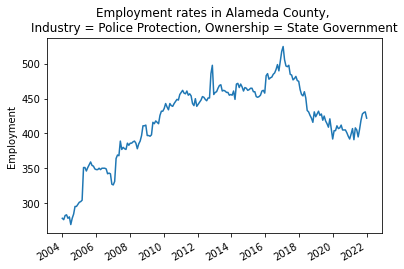

In [ ]:
emp_series.plot()
plt.title('Employment rates in Alameda County, \nIndustry = Police Protection, Ownership = State Government')
plt.ylabel('Employment')
plt.show()

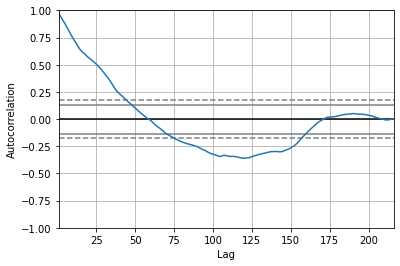

In [ ]:
autocorrelation_plot(emp_series)
plt.show()

# Augmented Dickey-Fuller Test to check stationarity

*   Null Hypothesis: H0: The time series is non-stationary.
*   Alterate Hypothesis: HA: The time series is stationary.




In [ ]:
adfuller(emp_series)

(-2.673978895930301,
 0.07865030367425219,
 2,
 213,
 {'1%': -3.461429147102264,
  '5%': -2.875206950587861,
  '10%': -2.5740544497344002},
 1414.4762145890663)



*   Test statistic: -2.673978895930301
*   P-value: 0.07865030367425219

Since the p-value is not less than .05, we fail to reject the null hypothesis. So the time series is non-stationary. This implies that the series does not have constant mean and variance over different time instants.



# Finding trend in the time series using Mann-Kendall Trend Test

*   Null Hypothesis: H0: There is no trend.
*   Alterate Hypothesis: HA: There is a trend in the data.

In [ ]:
import pymannkendall as mk
mk.original_test(emp_series)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=9.079562476621971, Tau=0.4152024117140396, s=9641.0, var_s=1127260.3333333333, slope=0.6206896551724138, intercept=363.7758620689655)

The p-value is 0, which indicates that there is trend in the data.

# Finding Seasonality 

In [ ]:
df = emp_series.rename("value")
df = df.to_frame()
df.reset_index(inplace=True)
df = df.rename(columns={"index": "time"})
ts = TimeSeriesData(df)

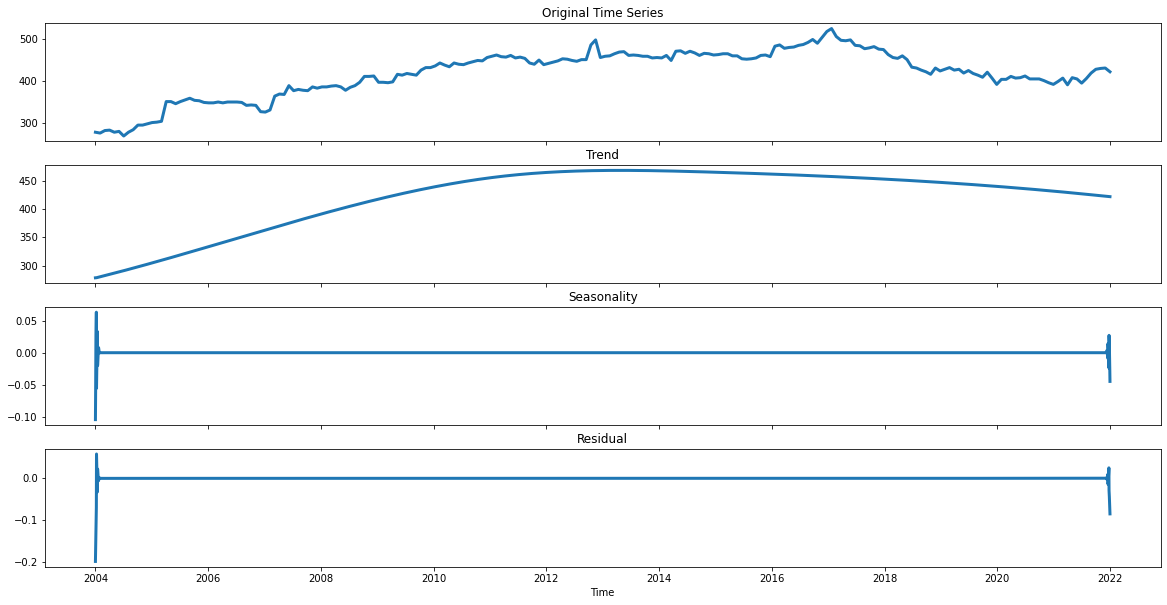

In [ ]:
decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
results = decomposer.decomposer()
fig = decomposer.plot()

* We can observe that there is no seasonality in the data. This means the employment rates do not depend much on the quarter and month of the year.

* Fast Fourier Transform Seasonality Detection

In [ ]:
from kats.detectors.seasonality import FFTDetector

fft_detector = FFTDetector(ts)
fft_detector.detector()

{'seasonality_presence': False, 'seasonalities': []}

# Time series prediction using ARIMA

In [ ]:
size = int(0.66 * len(emp_series))
train, test = emp_series.values[0:size], emp_series.values[size:len(emp_series)]

In [ ]:
history = list(train)
predictions = []

for t in range(len(test)):
	model = ARIMA(history, order=(25,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=461.918610, expected=462.000000
predicted=455.139218, expected=458.000000
predicted=464.117997, expected=483.000000
predicted=477.961627, expected=486.000000
predicted=485.223160, expected=478.000000
predicted=480.157434, expected=480.000000
predicted=479.724022, expected=481.000000
predicted=482.113402, expected=485.000000
predicted=484.633059, expected=487.000000
predicted=489.483627, expected=492.000000
predicted=490.777964, expected=499.000000
predicted=497.827776, expected=490.000000
predicted=487.561640, expected=504.000000
predicted=505.129589, expected=518.000000
predicted=515.817323, expected=525.000000
predicted=525.808712, expected=506.000000
predicted=499.079431, expected=497.000000
predicted=506.245490, expected=496.000000
predicted=492.961904, expected=498.000000
predicted=498.920983, expected=485.000000
predicted=491.251389, expected=484.000000
predicted=486.243230, expected=477.000000
predicted=471.538059, expected=479.000000
predicted=484.572879, expected=482

Test RMSE: 8.703


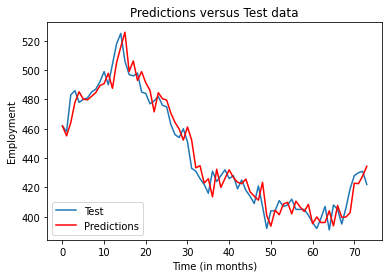

In [ ]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' %rmse)

plt.plot(test, label="Test")
plt.plot(predictions, color='red',label="Predictions")
plt.legend(loc="lower left")
plt.title('Predictions versus Test data')
plt.ylabel('Employment')
plt.xlabel('Time (in months)')
plt.show()

In [ ]:
s1 = pd.Series(test)
s2 = pd.Series(predictions)
print(s1.corr(s2, method='pearson'))

0.9728278870255008
